# Theme 1 - Ocean-Atmosphere Exchange
OOI Data Labs Education Nuggets

_Written by Lori Garzio, Rutgers University_

_Disclaimer: data used in this example were downloaded on May 26, 2020. The file format and/or contents could have changed._

**Objective**: Demonstrate how to download pCO2 Air-Sea data from the Global Argentine Basin Surface Mooring using the Machine-to-Machine (M2M) interface, calculate hourly averages and CO2 flux, and export the data as a .csv file.

In [1]:
# Notebook Setup
import requests
import os
import re
import xarray as xr
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## 1. Request Data from OOINet

* **Global Argentine Basin** - pCO2 Air-Sea data from the Apex Surface Mooring
    * Instrument: GA01SUMO-SBD12-04-PCO2AA000
    * Time range: 2015-11-01 to 2017-01-01
    * Delivery method: recovered_host
    * Data streams & parameters: 
        * pco2a_a_dcl_instrument_water_recovered: measured_water_co2, partial_pressure_co2_ssw, pco2_co2flux
        * pco2a_a_dcl_instrument_air_recovered: measured_air_co2, partial_pressure_co2_atm
    
As you will see later, we will need to manually calculate CO2 flux. This means we need to download two data streams from the collocated Bulk Meteorology instrument.

* Instrument: GA01SUMO-SBD12-06-METBKA000
* Data streams & parameters: 
    * metbk_a_dcl_instrument_recovered: met_salsurf, sea_surface_temperature
    * metbk_hourly: met_wind10m

The **request_data** function below sends data requests with inputs specified by the user to OOINet and returns the THREDDs urls where the downloaded data files can be found.

In [2]:
# enter your OOI API username and token, and directory where output .csv files are saved
API_USERNAME = ''
API_TOKEN = ''
save_dir = '/Users/lgarzio/Documents/OOI/Nuggets/'

In [3]:
def request_data(reference_designator, method, stream, start_date=None, end_date=None):
    site = reference_designator[:8]
    node = reference_designator[9:14]
    instrument = reference_designator[15:]

    # Create the request URL
    api_base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv'
    data_request_url = '/'.join((api_base_url, site, node, instrument, method, stream))

    # All of the following are optional, but you should specify a date range
    params = {
        'format': 'application/netcdf',
        'include_provenance': 'true',
        'include_annotations': 'true'
    }
    if start_date:
        params['beginDT'] = start_date
    if end_date:
        params['endDT'] = end_date

    # Make the data request
    r = requests.get(data_request_url, params=params, auth=(API_USERNAME, API_TOKEN))
    data = r.json()

    # Return just the THREDDS URL
    return data['allURLs'][0]

Now, use that **request_data** function to download data for these instruments. You only need to do this once! These lines are commented out to prevent accidental re-submission of data requests.

In [4]:
# GAwater_url = request_data('GA01SUMO-SBD12-04-PCO2AA000', 'recovered_host', 'pco2a_a_dcl_instrument_water_recovered',
#                            '2015-11-01T00:00:00.000Z', '2017-01-01T00:00:00.000Z')

# GAair_url = request_data('GA01SUMO-SBD12-04-PCO2AA000', 'recovered_host', 'pco2a_a_dcl_instrument_air_recovered',
#                          '2015-11-01T00:00:00.000Z', '2017-01-01T00:00:00.000Z')

# GAmet_url = request_data('GA01SUMO-SBD12-06-METBKA000', 'recovered_host', 'metbk_a_dcl_instrument_recovered',
#                          '2015-11-01T00:00:00.000Z', '2017-01-01T00:00:00.000Z')

# GAmet_hrly_url = request_data('GA01SUMO-SBD12-06-METBKA000', 'recovered_host', 'metbk_hourly',
#                               '2015-11-01T00:00:00.000Z', '2017-01-01T00:00:00.000Z')

# print('GAwater_url = %s' %GAwater_url)
# print('GAair_url = %s' %GAair_url)
# print('GAmet_url = %s' %GAmet_url)
# print('GAmet_hrly_url = %s' %GAmet_hrly_url)

## 2. Load Data Files

Copy the links to the THREDDs catalog above that resulted from the **request_data** function (to avoid re-requesting the data). Note: the urls must be surrounded by quotations. Depending on the data request, it may take several minutes for the request to fulfill. The request is complete when you receive an email from the system with the link to your data, and a status.txt file shows up in the THREDDs catalog that says "Complete".

In [5]:
GAwater_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200526T113723346Z-GA01SUMO-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_water_recovered/catalog.html'
GAair_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200526T113724173Z-GA01SUMO-SBD12-04-PCO2AA000-recovered_host-pco2a_a_dcl_instrument_air_recovered/catalog.html'
GAmet_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200526T113724538Z-GA01SUMO-SBD12-06-METBKA000-recovered_host-metbk_a_dcl_instrument_recovered/catalog.html'
GAmet_hrly_url = 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/lgarzio@marine.rutgers.edu/20200526T113724916Z-GA01SUMO-SBD12-06-METBKA000-recovered_host-metbk_hourly/catalog.html'

The **get_data** function below:
* selects the appropriate datasets in a THREDDs catalog by selecting NetCDF files, removing collocated datasets (if provided), and removing deployments that aren't specified (if provided)
* creates an empty dictionary with placeholders to populate with data just for variables of interest
* creates another dictionary to store the units for the variables of interest
* opens the dataset(s), extracts the data and units for the variables of interest and adds them to the dictionaries
* converts the data dictionary to a dataframe
* returns the dataframe and the dictionary containing the variable units. 

This type of function is most useful when working with multiple large/dense datasets, but is also fine for working with smaller datasets.

In [6]:
def get_data(url, variables, deployments=None):
    # Function to grab all data from specified directory
    tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
    dataset = requests.get(url).text
    ii = re.findall(r'href=[\'"]?([^\'" >]+)', dataset)
    # x = re.findall(r'(ooi/.*?.nc)', dataset)
    x = [y for y in ii if y.endswith('.nc')]
    for i in x:
        if i.endswith('.nc') == False:
            x.remove(i)
    for i in x:
        try:
            float(i[-4])
        except:
            x.remove(i)
    # dataset = [os.path.join(tds_url, i) for i in x]
    datasets = [os.path.join(tds_url, i.split('=')[-1]) for i in x]

    # remove deployments not in deployment list, if given
    if deployments is not None:
        deploy = ['deployment{:04d}'.format(j) for j in deployments]
        datasets = [k for k in datasets if k.split('/')[-1].split('_')[0] in deploy]

    # remove collocated data files if necessary
    catalog_rms = url.split('/')[-2][20:]
    selected_datasets = []
    for d in datasets:
        if catalog_rms == d.split('/')[-1].split('_20')[0][15:]:
            selected_datasets.append(d)

    # create a dictionary to populate with data from the selected datasets
    data_dict = {'time': np.array([], dtype='datetime64[ns]')}
    unit_dict = {}
    for v in variables:
        data_dict.update({v: np.array([])})
        unit_dict.update({v: []})
    print('Appending data from files')

    for sd in selected_datasets:
        ds = xr.open_dataset(sd, mask_and_scale=False)
        data_dict['time'] = np.append(data_dict['time'], ds['time'].values)
        for var in variables:
            data_dict[var] = np.append(data_dict[var], ds[var].values)
            try:
                units = ds[var].units
                if units not in unit_dict[var]:
                    unit_dict[var].append(units)
            except AttributeError:
                continue

    # convert dictionary to a dataframe
    df = pd.DataFrame(data_dict)
    df.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

    return df, unit_dict

Now we can specify the variables we want and get the data for these datasets. In this case, if you go to the opendap catalog links fpr the PCO2 data, you will see data files for different instruments and data streams that weren't specifically requested. All of these extra data files are included in the folder because parameters from those datasets are used to calculate CO2 flux. The **get_data** function only opens files for the instrument and stream that was specifically requested: see the '# remove collocated data files if necessary' section.

In [7]:
# Specify the pCO2 variables of interest and get the data
wvars = ['measured_water_co2', 'partial_pressure_co2_ssw', 'pco2_co2flux']
avars = ['measured_air_co2', 'partial_pressure_co2_atm']

GAwater_data, GAwater_units = get_data(GAwater_url, wvars)
GAair_data, GAair_units = get_data(GAair_url, avars)

print(GAwater_units)
print(GAair_units)

Appending data from files
Appending data from files
{'measured_water_co2': ['ppm'], 'partial_pressure_co2_ssw': ['µatm'], 'pco2_co2flux': ['mol m-2 s-1']}
{'measured_air_co2': ['ppm'], 'partial_pressure_co2_atm': ['µatm']}


In [8]:
# print out the first few lines of each dataset
GAwater_data.head()

,time,measured_water_co2,partial_pressure_co2_ssw,pco2_co2flux
97188,2015-11-14 21:26:58.378000384,368.420013,370.147113,-9999999.0
97189,2015-11-14 21:26:59.480999936,368.600006,370.327967,-9999999.0
97190,2015-11-14 21:27:01.081999872,368.559998,370.287750,-9999999.0
97191,2015-11-14 21:27:02.682000384,368.440002,370.167222,-9999999.0
97192,2015-11-14 21:27:04.282999808,368.440002,370.167222,-9999999.0


In [9]:
GAair_data.head()

,time,measured_air_co2,partial_pressure_co2_atm
97188,2015-11-14 21:27:04.331999744,394.040009,395.498335
97189,2015-11-14 21:27:04.374000128,394.059998,395.518412
97190,2015-11-14 21:27:04.416000000,393.950012,395.408000
97191,2015-11-14 21:27:04.459000320,393.940002,395.397946
97192,2015-11-14 21:27:04.500999680,393.899994,395.357791


## Quick Data Plots
It looks like we have some data, so let's make some quick timeseries plots.

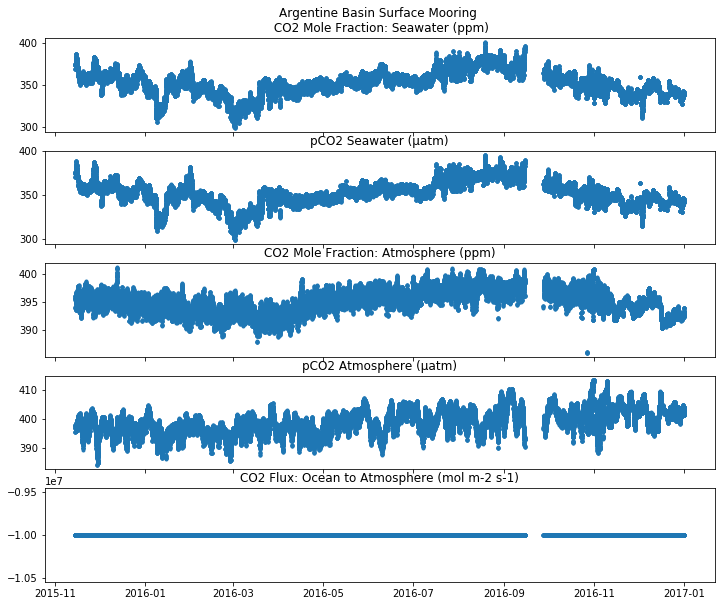

In [10]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
ax1.plot(GAwater_data['time'], GAwater_data['measured_water_co2'], '.')
ax2.plot(GAwater_data['time'], GAwater_data['partial_pressure_co2_ssw'], '.')
ax3.plot(GAair_data['time'], GAair_data['measured_air_co2'], '.')
ax4.plot(GAair_data['time'], GAair_data['partial_pressure_co2_atm'], '.')
ax5.plot(GAwater_data['time'], GAwater_data['pco2_co2flux'], '.')
ax1.set_title('Argentine Basin Surface Mooring \n CO2 Mole Fraction: Seawater ({})'.format(GAwater_units['measured_water_co2'][0]))
ax2.set_title('pCO2 Seawater ({})'.format(GAwater_units['partial_pressure_co2_ssw'][0]))
ax3.set_title('CO2 Mole Fraction: Atmosphere ({})'.format(GAair_units['measured_air_co2'][0]))
ax4.set_title('pCO2 Atmosphere ({})'.format(GAair_units['partial_pressure_co2_atm'][0]))
ax5.set_title('CO2 Flux: Ocean to Atmosphere ({})'.format(GAwater_units['pco2_co2flux'][0]));

You can see from the bottom panel of this plot that the CO2 flux provided in the files is just an array of fill values (-9999999). There is an issue with this calculation in the OOI system for the Pioneer and Global Surface Moorings, which means we have to calculate that ourselves. To do this we need to grab data from the collocated METBK: the regular, high-resolution METBK dataset contains the sea surface salinity and temperature variables, and the hourly dataset contains the modeled windspeeds at 10m.

We can use the [pCO2 function](https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/co2_functions.py) the OOI system uses, named pco2_co2flux (lines 374-440), copied below.

In [11]:
def pco2_co2flux(pco2w, pco2a, u10, t, s):
    """
    Description:
        OOI Level 2 core date product CO2FLUX is an estimate of the CO2 flux
        from the ocean to the atmosphere. It is computed using data from the
        pCO2 air-sea (PCO2A) and bulk meteorology (METBK) families of
        instruments.
    Implemented by:
        2012-03-28: Mathias Lankhorst. Original Matlab code.
        2013-04-20: Christopher Wingard. Initial python code.
    Usage:
        flux = pco2_co2flux(pco2w, pco2a, u10, t, s)
            where
        flux = estimated flux of CO2 from the ocean to atmosphere [mol m-2 s-1]
               (CO2FLUX_L2)
        pco2w = partial pressure of CO2 in sea water [uatm] (PCO2SSW_L1)
        pco2a = partial pressure of CO2 in air [uatm] (PCO2ATM_L1)
        u10 = normalized wind speed at 10 m height from METBK [m s-1] (WIND10M_L2)
        t = sea surface temperature from METBK [deg_C] (TEMPSRF_L1)
        s = sea surface salinity from METBK [psu] (SALSURF_L2)
    References:
        OOI (2012). Data Product Specification for Flux of CO2 into the
            Atmosphere. Document Control Number 1341-00270.
            https://alfresco.oceanobservatories.org/ (See: Company Home >>
            OOI >> Controlled >> 1000 System Level >>
            1341-00270_Data_Product_SPEC_CO2FLUX_OOI.pdf)
    """
    # convert micro-atm to atm
    pco2a = pco2a / 1.0e6
    pco2w = pco2w / 1.0e6

    # Compute Schmidt number (after Wanninkhof, 1992, Table A1)
    Sc = 2073.1 - (125.62 * t) + (3.6276 * t**2) - (0.043219 * t**3)

    # Compute gas transfer velocity (after Sweeney et al. 2007, Fig. 3 and Table 1)
    k = 0.27 * u10**2 * np.sqrt(660.0 / Sc)

    # convert cm h-1 to m s-1
    k = k / (100.0 * 3600.0)

    # Compute the absolute temperature
    T = t + 273.15

    # Compute solubility (after Weiss 1974, Eqn. 12 and Table I).
    # Note that there are two versions, one for units per volume and
    # one per mass. Here, the volume version is used.
    # mol atm-1 m-3
    T100 = T / 100
    K0 = 1000 * np.exp(-58.0931 + (90.5069 * (100/T)) + (22.2940 * np.log(T100)) +
                       s * (0.027766 - (0.025888 * T100) + (0.0050578 * T100**2)))

    # mol atm-1 kg-1
    #K0 = np.exp(-60.2409 + (93.4517 * (100/T)) + (23.3585 * np.log(T100)) +
    #            s * (0.023517 - (0.023656 * T100) + (0.0047036 * T100**2)))

    # Compute flux (after Wanninkhof, 1992, eqn. A2)
    flux = k * K0 * (pco2w - pco2a)
    return flux

In [12]:
# get the METBK data
met_vars = ['met_salsurf', 'sea_surface_temperature']
met_hrly_vars = ['met_wind10m']

GAmet_data, GAmet_units = get_data(GAmet_url, met_vars)
GAmet_hrly_data, GAmet_hrly_units = get_data(GAmet_hrly_url, met_hrly_vars)

print(GAmet_units)
print(GAmet_hrly_units)

Appending data from files
Appending data from files
{'met_salsurf': ['1'], 'sea_surface_temperature': ['ºC']}
{'met_wind10m': ['m s-1']}


In [13]:
GAmet_data.head()

,time,met_salsurf,sea_surface_temperature
94931,2015-11-14 21:06:57.470000128,34.527679,12.259
94932,2015-11-14 21:08:02.144999936,34.529394,12.233
94933,2015-11-14 21:08:34.319999488,34.521399,12.270
94934,2015-11-14 21:09:38.687999488,34.527149,12.311
94935,2015-11-14 21:10:43.384000000,34.521280,12.331


In [14]:
GAmet_hrly_data.head()

,time,met_wind10m
10191,2015-04-24 20:41:37.080000000,-9999999.0
1631,2015-11-14 21:36:57.470000128,NaN
1632,2015-11-14 22:36:57.470000128,NaN
1633,2015-11-14 23:36:57.470000128,NaN
1634,2015-11-15 00:29:43.624999936,NaN


The salinity and temperature data are recorded about once every minute, and the wind speeds are from a derived data stream with hourly samples. The description of met_wind10m is "The modelled windspeed at a reference height of 10m". We'll calculate hourly averages for each of these datasets, merge them, and then we can calculate CO2 flux.

In [15]:
# calculate hourly averages for the pCO2 data
GAwater_hourly = GAwater_data.resample('H', on='time').mean().dropna(how='all').reset_index()
GAair_hourly = GAair_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# merge the datasets
GApco2_data = pd.merge(GAwater_hourly, GAair_hourly, on=['time'], how='outer')
GApco2_data.head()

,time,measured_water_co2,partial_pressure_co2_ssw,pco2_co2flux,measured_air_co2,partial_pressure_co2_atm
0,2015-11-14 21:00:00,371.333005,372.889132,-9999999.0,394.723001,396.183855
1,2015-11-14 22:00:00,374.229996,375.429888,-9999999.0,395.883997,397.700805
2,2015-11-14 23:00:00,378.427002,379.639495,-9999999.0,395.595001,397.449503
3,2015-11-15 00:00:00,381.580997,382.428019,-9999999.0,395.734998,397.590159
4,2015-11-15 01:00:00,376.529001,377.550916,-9999999.0,395.283002,397.136047


In [16]:
# replace fill values with NaNs
GAmet_hrly_data[GAmet_hrly_data == -9999999] = np.nan

# calculate hourly averages for the MET data
GAmet_hourly = GAmet_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# taking the hourly average of the already hourly-averaged dataset will just get rid of NaN rows, and
# will reset the timestamp to be on the hour so it can easily be merged with the other datasets
GAmet_hourly2 = GAmet_hrly_data.resample('H', on='time').mean().dropna(how='all').reset_index()

# merge the datasets
merge1 = pd.merge(GAmet_hourly, GAmet_hourly2, on=['time'], how='outer')
GApco2_data = pd.merge(merge1, GApco2_data, on=['time'], how='outer' )

GApco2_data.head()

,time,met_salsurf,sea_surface_temperature,met_wind10m,measured_water_co2,partial_pressure_co2_ssw,pco2_co2flux,measured_air_co2,partial_pressure_co2_atm
0,2015-11-14 21:00:00,34.534214,12.378315,NaN,371.333005,372.889132,-9999999.0,394.723001,396.183855
1,2015-11-14 22:00:00,34.532263,12.433678,NaN,374.229996,375.429888,-9999999.0,395.883997,397.700805
2,2015-11-14 23:00:00,34.531189,12.442016,NaN,378.427002,379.639495,-9999999.0,395.595001,397.449503
3,2015-11-15 00:00:00,34.531626,12.424950,NaN,381.580997,382.428019,-9999999.0,395.734998,397.590159
4,2015-11-15 01:00:00,34.531360,12.343867,NaN,376.529001,377.550916,-9999999.0,395.283002,397.136047


In [17]:
# use the pco2_co2flux function above to calculate flux
pco2w = np.array(GApco2_data['partial_pressure_co2_ssw'])
pco2a = np.array(GApco2_data['partial_pressure_co2_atm'])
u10 = np.array(GApco2_data['met_wind10m'])
t = np.array(GApco2_data['sea_surface_temperature'])
s = np.array(GApco2_data['met_salsurf'])
co2flux_calc = pco2_co2flux(pco2w, pco2a, u10, t, s)

# add the resulting data to the dataframe
GApco2_data['co2flux_calc'] = co2flux_calc

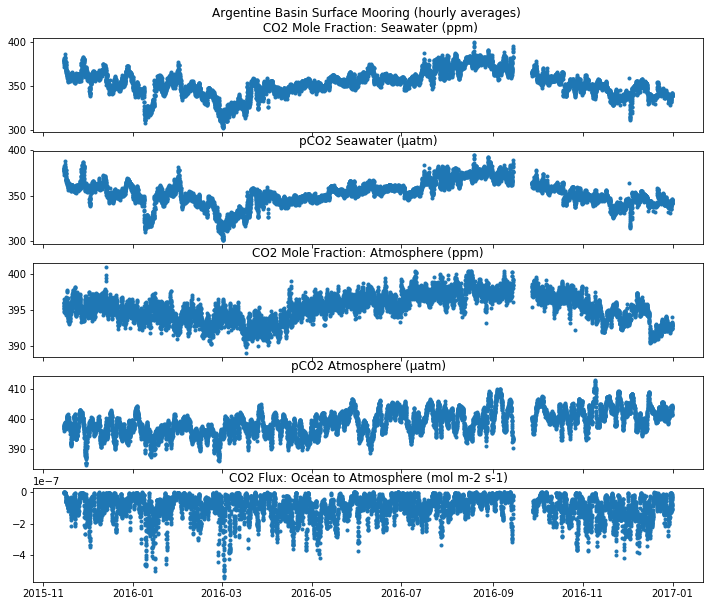

In [18]:
# plot the hourly averaged data with the calculated CO2 flux
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, sharex=True, figsize=(12, 10))
ax1.plot(GApco2_data['time'], GApco2_data['measured_water_co2'], '.')
ax2.plot(GApco2_data['time'], GApco2_data['partial_pressure_co2_ssw'], '.')
ax3.plot(GApco2_data['time'], GApco2_data['measured_air_co2'], '.')
ax4.plot(GApco2_data['time'], GApco2_data['partial_pressure_co2_atm'], '.')
ax5.plot(GApco2_data['time'], GApco2_data['co2flux_calc'], '.')
ax1.set_title('Argentine Basin Surface Mooring (hourly averages) \n CO2 Mole Fraction: Seawater ({})'.format(GAwater_units['measured_water_co2'][0]))
ax2.set_title('pCO2 Seawater ({})'.format(GAwater_units['partial_pressure_co2_ssw'][0]))
ax3.set_title('CO2 Mole Fraction: Atmosphere ({})'.format(GAair_units['measured_air_co2'][0]))
ax4.set_title('pCO2 Atmosphere ({})'.format(GAair_units['partial_pressure_co2_atm'][0]))
ax5.set_title('CO2 Flux: Ocean to Atmosphere ({})'.format(GAwater_units['pco2_co2flux'][0]));

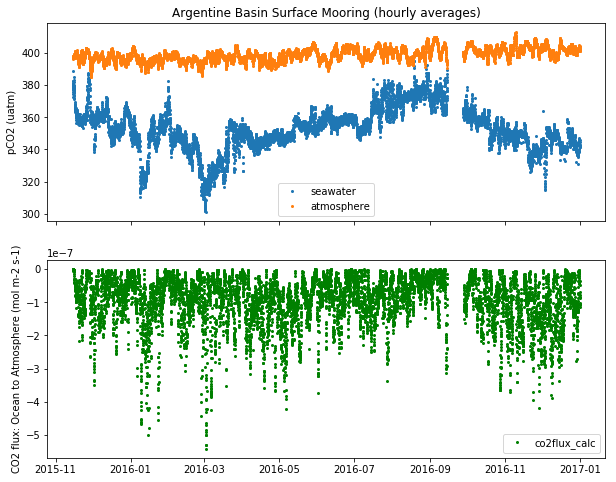

In [19]:
# plot pCO2 of seawater and atmosphere on the same plot, along with flux
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(10, 8))
ax1.plot(GApco2_data['time'], GApco2_data['partial_pressure_co2_ssw'], '.', markersize=4, label='seawater')
ax1.plot(GApco2_data['time'], GApco2_data['partial_pressure_co2_atm'], '.', markersize=4, label='atmosphere')
ax2.plot(GApco2_data['time'], GApco2_data['co2flux_calc'], 'g.', markersize=4, label='co2flux_calc')
ax1.legend()
ax2.legend()
ax1.set_ylabel('pCO2 (uatm)')
ax2.set_ylabel('CO2 flux: Ocean to Atmosphere (mol m-2 s-1)')
ax1.set_title('Argentine Basin Surface Mooring (hourly averages)');

## 3. Merge and export
Now that we have the downsampled dataset and calculated CO2 flux, let's rename the columns and export as a .csv file.

In [20]:
# first, drop the columns we don't need in the final export
GApco2_data = GApco2_data.drop(columns=['pco2_co2flux', 'met_salsurf', 'sea_surface_temperature', 'met_wind10m'])

In [21]:
# rename the columns and add units
GApco2_data = GApco2_data.rename(columns={'measured_water_co2': 'CO2 Mole Fraction Seawater ({})'.format(GAwater_units['measured_water_co2'][0]),
                                         'partial_pressure_co2_ssw': 'pCO2 Seawater ({})'.format(GAwater_units['partial_pressure_co2_ssw'][0]),
                                         'co2flux_calc': 'CO2 Flux Calculated ({})'.format(GAwater_units['pco2_co2flux'][0]),
                                         'measured_air_co2':'CO2 Mole Fraction Atmosphere ({})'.format(GAair_units['measured_air_co2'][0]),
                                         'partial_pressure_co2_atm': 'pCO2 Atmosphere ({})'.format(GAair_units['partial_pressure_co2_atm'][0])})

GApco2_data.sort_values(by=['time'], inplace=True)  # make sure the timestamps are in ascending order

In [22]:
# export to .csv
GApco2_data.to_csv(os.path.join(save_dir, 'Theme1_pCO2_GA01SUMO.csv'), index=False)